<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week8.do.txt --no_mako -->
<!-- dom:TITLE: March 13-17,2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories -->

# March 13-17,2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Mar 13, 2023**

Copyright 1999-2023, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Solving quantum mechanical problems

1. Simple Hamiltonian, the Lipkin model

2. Introducing the Variational Quantum Eigensolver (VQE)

3. Analyzing the solution of eigenvalue problems using the Lipkin model

* [Video of lecture](https://youtu.be/ffIwxiUJGT4)

## Simple Hamiltonian, the Lipkin model

We will study a schematic model (the Lipkin model, see Nuclear
Physics **62** (1965) 188), for the interaction among  $2$ and more 
fermions that can occupy two different energy levels. For four fermions, the case we consider first here, each levels has degeneration $d=4$. The two levels have quantum numbers $\sigma=\pm 1$,
with the upper level having  $\sigma=+1$ and energy
$\varepsilon_{1}=
\varepsilon/2$. The lower level  has $\sigma=-1$ and energy
$\varepsilon_{2}=-\varepsilon/2$. 
In addition, the substates  of each level are characterized  
by the quantum numbers $p=1,2,3,4$.

We define the single-particle states (for the four fermion case which we will work on here)

$$
\vert u_{\sigma =-1,p}\rangle=a_{-p}^{\dagger}\vert 0\rangle
\hspace{1cm}
\vert u_{\sigma =1,p}\rangle=a_{+p}^{\dagger}\vert 0\rangle.
$$

The single-particle states span an orthonormal basis.
The Hamiltonian of the system is given by

$$
\begin{array}{ll}
\hat{H}=&\hat{H}_{0}+\hat{H}_{1}+\hat{H}_{2}\\
&\\
\hat{H}_{0}=&\frac{1}{2}\varepsilon\sum_{\sigma ,p}\sigma
a_{\sigma,p}^{\dagger}a_{\sigma ,p}\\
&\\
\hat{H}_{1}=&\frac{1}{2}V\sum_{\sigma ,p,p'}
a_{\sigma,p}^{\dagger}a_{\sigma ,p'}^{\dagger}
a_{-\sigma ,p'}a_{-\sigma ,p}\\
&\\
\hat{H}_{2}=&\frac{1}{2}W\sum_{\sigma ,p,p'}
a_{\sigma,p}^{\dagger}a_{-\sigma ,p'}^{\dagger}
a_{\sigma ,p'}a_{-\sigma ,p}\\
&\\
\end{array}
$$

where $V$ and $W$ are constants. The operator 
$H_{1}$ can move pairs of fermions
while $H_{2}$ is a spin-exchange term. The latter
moves a pair of fermions from a state $(p\sigma ,p' -\sigma)$ to a state
$(p-\sigma ,p'\sigma)$.

We are going to rewrite the above Hamiltonian in terms of so-called  quasispin operators

$$
\begin{array}{ll}
\hat{J}_{+}=&\sum_{p}
a_{p+}^{\dagger}a_{p-}\\
&\\
\hat{J}_{-}=&\sum_{p}
a_{p-}^{\dagger}a_{p+}\\
&\\
\hat{J}_{z}=&\frac{1}{2}\sum_{p\sigma}\sigma
a_{p\sigma}^{\dagger}a_{p\sigma}\\
&\\
\hat{J}^{2}=&J_{+}J_{-}+J_{z}^{2}-J_{z}\\
&\\
\end{array}
$$

We show here that these operators obey the commutation relations for angular momentum.

We can in turn express $\hat{H}$ in terms of the above quasispin operators and the number operator

$$
\hat{N}=\sum_{p\sigma}
a_{p\sigma}^{\dagger}a_{p\sigma}.
$$

We have the following quasispin operators

<!-- Equation labels as ordinary links -->
<div id="eq:Jpm"></div>

$$
\begin{equation}
J_{\pm} = \sum_p a_{p\pm}^\dagger a_{p\mp},
\label{eq:Jpm} \tag{1} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:Jz"></div>

$$
\begin{equation} 
J_{z} = \frac{1}{2}\sum_{p,\sigma} \sigma a_{p\sigma}^\dagger a_{p\sigma},
\label{eq:Jz} \tag{2} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:J2"></div>

$$
\begin{equation} 
J^{2} = J_+ J_- + J_z^2 - J_z,
\label{eq:J2} \tag{3}
\end{equation}
$$

and we want to compute the commutators

$$
[J_z,J_\pm], \quad [J_+,J_-], \quad [J^2,J_\pm] \quad \text{og} \quad 
[J^2,J_z].
$$

Let us start with the first one and inserting for  $J_z$ and $J_\pm$ given by the equations ([2](#eq:Jz)) and ([1](#eq:Jpm)), respectively, we obtain

$$
\begin{align*}
[J_z,J_\pm] &= J_z J_\pm - J_\pm J_z \\
%
&= \left( \frac{1}{2}\sum_{p,\sigma} \sigma a_{p\sigma}^\dagger a_{p\sigma} \right)
\left( \sum_{p'} a_{p'\pm}^\dagger a_{p'\mp} \right) -
\left( \sum_{p'} a_{p'\pm}^\dagger a_{p'\mp} \right)
\left( \frac{1}{2}\sum_{p,\sigma} \sigma a_{p\sigma}^\dagger a_{p\sigma} \right) \\
&= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left( a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} - a_{p'\pm}^\dagger a_{p'\mp} a_{p\sigma}^\dagger a_{p\sigma} \right).
\end{align*}
$$

Using the commutation relations for the creation and annihilation operators

<!-- Equation labels as ordinary links -->
<div id="eq:al,ak"></div>

$$
\begin{equation}
\{ a_l,a_k \} = 0, \label{eq:al,ak} \tag{4} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:ald,akd"></div>

$$
\begin{equation} 
\{ a_l^\dagger , a_k^\dagger \} = 0, \label{eq:ald,akd} \tag{5} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:ald,ak"></div>

$$
\begin{equation} 
\{ a_l^\dagger , a_k \} = \delta_{lk}, \label{eq:ald,ak} \tag{6}
\end{equation}
$$

in order to move the operators in the right product to be in the same order as those in the lefthand product

$$
\begin{align*}
[J_z,J_\pm] &= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left(
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \left( \delta_{p' p} \delta_{\mp \sigma} - a_{p\sigma}^\dagger a_{p'\mp} \right) a_{p\sigma} \right) \\
&= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left(
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \delta_{p' p} \delta_{\mp \sigma} a_{p\sigma} +
a_{p'\pm}^\dagger a_{p\sigma}^\dagger a_{p'\mp} a_{p\sigma} \right), \\
\end{align*}
$$

which results in

$$
\begin{align*}
[J_z,J_\pm]
&= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left(
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \delta_{pp'} \delta_{\mp \sigma} a_{p\sigma} +
a_{p\sigma}^\dagger a_{p'\pm}^\dagger a_{p\sigma} a_{p'\mp} \right) \\
&= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left(
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \delta_{pp'} \delta_{\mp \sigma} a_{p\sigma} +
a_{p\sigma}^\dagger \left( \delta_{pp'} \delta_{\pm \sigma} - a_{p\sigma} a_{p'\pm}^\dagger \right) a_{p'\mp} \right) \\
&= \frac{1}{2} \sum_{p,p',\sigma} \sigma \left(
a_{p\sigma}^\dagger \delta_{pp'} \delta_{\pm \sigma} a_{p'\mp} -
a_{p'\pm}^\dagger \delta_{pp'} \delta_{\mp \sigma} a_{p\sigma} \right). \\
\end{align*}
$$

The last equality leads to

$$
\begin{align*}
[J_z,J_\pm] &= \frac{1}{2} \sum_p \left(
(\pm 1) a_{p\pm}^\dagger a_{p\mp} - (\mp 1)
a_{p\pm}^\dagger a_{p\mp} \right) =
\pm \frac{1}{2} \sum_p \left(
a_{p\pm}^\dagger a_{p\mp} + (\pm 1)
a_{p\pm}^\dagger a_{p\mp} \right) \\
&= \pm \sum_p a_{p\pm}^\dagger a_{p\mp} = \pm J_\pm,
\end{align*}
$$

where the last results follows from comparing with Eq. ([1](#eq:Jpm)).

We can then continue with the next commutation relation, using Eq. ([1](#eq:Jpm)),

$$
\begin{align*}
[J_+,J_-] &= J_+ J_- - J_- J_+ \\
&= \left( \sum_p a_{p'+}^\dagger a_{p-} \right)
\left( \sum_{p'} a_{p'-}^\dagger a_{p'+} \right) -
\left( \sum_{p'} a_{p'-}^\dagger a_{p'+} \right)
\left( \sum_p a_{p+}^\dagger a_{p-} \right) \\
&= \sum_{p,p'} \left(
a_{p'+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} -
a_{p'-}^\dagger a_{p'+} a_{p+}^\dagger a_{p-} \right) \\
&= \sum_{p,p'} \left(
a_{p'+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} -
a_{p'-}^\dagger \left( \delta_{++} \delta_{pp'} -
a_{p+}^\dagger a_{p'+} \right) a_{p-} \right) \\
&= \sum_{p,p'} \left(
a_{p'+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} -
a_{p'-}^\dagger \delta_{pp'} a_{p-} +
a_{p'-}^\dagger a_{p+}^\dagger a_{p'+} a_{p-} \right) \\
&= \sum_{p,p'} \left(
a_{p'+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} -
a_{p'-}^\dagger \delta_{pp'} a_{p-} +
a_{p+}^\dagger a_{p'-}^\dagger a_{p-} a_{p'+} \right) \\
&= \sum_{p,p'} \left(
a_{p'+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} -
a_{p'-}^\dagger \delta_{pp'} a_{p-} +
a_{p+}^\dagger \left( \delta_{--} \delta_{pp'} -
a_{p-} a_{p'-}^\dagger \right) a_{p'+} \right) \\
&= \sum_{p,p'} \left(
a_{p+}^\dagger \delta_{pp'} a_{p'+} -
a_{p'-}^\dagger \delta_{pp'} a_{p-} \right), \\
\end{align*}
$$

which results in

$$
[J_+,J_-] = \sum_p \left(
a_{p+}^\dagger a_{p+} -
a_{p-}^\dagger a_{p-} \right) = 2J_z,
$$

It is straightforward to show that

$$
[J^2, J_\pm] = [J_+ J_- + J_z^2 - J_z, J_\pm] =
[J_+ J_-, J_\pm] + [J_z^2, J_\pm] - [J_z, J_\pm].
$$

Using the relations

<!-- Equation labels as ordinary links -->
<div id="eq:ab,c"></div>

$$
\begin{equation}
[AB,C] = A[B,C] + [A,C]B, \label{eq:ab,c} \tag{7} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:a,bc"></div>

$$
\begin{equation} 
[A,BC] = [A,B]C + B[A,C], \label{eq:a,bc} \tag{8}
\end{equation}
$$

we obtain

$$
[J^2, J_\pm] =
J_+ [J_-,J_\pm] + [J_+,J_\pm] J_- + J_z [J_z,J_\pm] + [J_z,J_\pm] J_z - [J_z,J_\pm].
$$

Finally, from the above it follows that

$$
\begin{align*}
[J^2, J_+] &= -2J_+ J_z + J_z [J_z,J_+] + [J_z,J_+] J_z - [J_z,J_+] \\
&= -2J_+ J_z + J_z J_+ + J_+ J_z - J_+ \\
&= -2J_+ J_z + J_+ + J_+ J_z + J_+ J_z - J_+ = 0,
\end{align*}
$$

and

$$
\begin{align*}
[J^2, J_-] &= 2J_z J_- + J_z [J_z,J_-] + [J_z,J_-] J_z - [J_z,J_-] \\
&= 2J_z J_- - J_z J_- - J_- J_z + J_- \\
&= J_z J_- - (J_z J_- + J_-) + J_- = 0.
\end{align*}
$$

Our last commutator is given by

$$
\begin{align*}
[J^2,J_z] &= [J_+ J_- + J_z^2 - J_z, J_z] \\
&= [J_+ J_-, J_z] + [J_z^2, J_z] - [J_z, J_z] \\
&= J_+ [J_-, J_z] + [J_+,J_z] J_- \\
&= J_+ J_- - J_+ J_- = 0
\end{align*}
$$

Summing up we have

<!-- Equation labels as ordinary links -->
<div id="eq:kJzJpm"></div>

$$
\begin{equation}
[J_z, J_\pm] = \pm J_\pm, \label{eq:kJzJpm} \tag{9} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:kJpJm"></div>

$$
\begin{equation} 
[J_+, J_-] = 2J_z, \label{eq:kJpJm} \tag{10} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:kJ2Jpm"></div>

$$
\begin{equation} 
[J^2, J_\pm] = 0, \label{eq:kJ2Jpm} \tag{11} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:kJ2Jz"></div>

$$
\begin{equation} 
[J^2,J_z] = 0, \label{eq:kJ2Jz} \tag{12}
\end{equation}
$$

which are the standard commutation relations for angular (or orbital) momentum $L_\pm$, $L_z$ og $L^2$.

## Rewriting the Hamiltonian

We wrote the above Hamiltonian as

$$
H = H_0 + H_1 +H_2,
$$

with

$$
H_0 = \frac{1}{2} \varepsilon \sum_{p\sigma}\sigma a_{p\sigma}^{\dagger}a_{p\sigma},
$$

and

$$
H_1 = \frac{1}{2} V \sum_{p,p',\sigma} a_{p\sigma}^\dagger a_{p'\sigma}^\dagger a_{p'-\sigma} a_{p-\sigma},
$$

and

$$
H_{2} = \frac{1}{2} W \sum_{p,p',\sigma}a_{p\sigma}^\dagger a_{p'-\sigma}^\dagger a_{p'\sigma}a_{p-\sigma}.
$$

We will now rewrite the Hamiltonian in terms of the above quasi-spin operators and the number operator

<!-- Equation labels as ordinary links -->
<div id="eq:N"></div>

$$
\begin{equation}
N = \sum_{p,\sigma} a_{p\sigma}^\dagger a_{p\sigma}.
\label{eq:N} \tag{13}
\end{equation}
$$

Going through each term of the Hamiltonian and using the expressions for the quasi-spin operators we obtain

<!-- Equation labels as ordinary links -->
<div id="eq:H0ny"></div>

$$
\begin{equation}
H_0 = \varepsilon J_z.
\label{eq:H0ny} \tag{14}
\end{equation}
$$

Moving over to $H_1$ and using the anti-commutation relations ([4](#eq:al,ak)) through ([6](#eq:ald,ak)) we obtain

$$
\begin{align*}
H_1 &= \frac{1}{2} V \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p'\sigma}^\dagger a_{p'-\sigma} a_{p-\sigma} \\
&= \frac{1}{2} V \sum_{p,p',\sigma}
-a_{p\sigma}^\dagger a_{p'\sigma}^\dagger a_{p-\sigma} a_{p'-\sigma} \\
&= \frac{1}{2} V \sum_{p,p',\sigma}
-a_{p\sigma}^\dagger \left( \delta_{pp'} \delta_{\sigma -\sigma} - a_{p-\sigma} a_{p'\sigma}^\dagger \right) a_{p'-\sigma} \\
&= \frac{1}{2} V \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p-\sigma} a_{p'\sigma}^\dagger a_{p'-\sigma} \\
\end{align*}
$$

Rewriting the sum  over $\sigma$ we arrive at

$$
\begin{align*}
H_1 &= \frac{1}{2} V\sum_{p,p'}
a_{p+}^\dagger a_{p-} a_{p'+}^\dagger a_{p'-} +
a_{p-}^\dagger a_{p+} a_{p'-}^\dagger a_{p'+} \\
&= \frac{1}{2} V \left[ \sum_p \left( a_{p+}^\dagger a_{p-} \right)
\sum_{p'} \left( a_{p'+}^\dagger a_{p'-} \right) +
\sum_p \left( a_{p-}^\dagger a_{p+} \right)
\sum_{p'} \left( a_{p'-}^\dagger a_{p'+} \right) \right] \\
&= \frac{1}{2} V \left[ J_+ J_+ + J_- J_- \right] = \frac{1}{2} V \left[ J_+^2 + J_-^2 \right] ,
\end{align*}
$$

which leads to

<!-- Equation labels as ordinary links -->
<div id="eq:H1ny"></div>

$$
\begin{equation}
H_1 = \frac{1}{2} V \left( J_+^2 + J_-^2 \right).
\label{eq:H1ny} \tag{15}
\end{equation}
$$

Finally, we rewrite the last term

$$
\begin{align*}
H_2 &= \frac{1}{2} W \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p'-\sigma}^\dagger a_{p'\sigma} a_{p-\sigma} \\
&= \frac{1}{2} W \sum_{p,p',\sigma}
-a_{p\sigma}^\dagger a_{p'-\sigma}^\dagger a_{p-\sigma} a_{p'\sigma} \\
&= \frac{1}{2} W \sum_{p,p',\sigma}
-a_{p\sigma}^\dagger \left( \delta_{pp'} \delta_{-\sigma -\sigma} -
a_{p-\sigma} a_{p'-\sigma}^\dagger \right) a_{p'\sigma} \\
&= \frac{1}{2} W \sum_{p,p',\sigma}
-a_{p\sigma}^\dagger \delta_{pp'} a_{p'\sigma} +
a_{p\sigma}^\dagger a_{p-\sigma} a_{p'-\sigma}^\dagger a_{p'\sigma} \\
&= \frac{1}{2} W \left( -\sum_{p,\sigma}
a_{p\sigma}^\dagger a_{p\sigma} +
\sum_{p,p',\sigma} a_{p\sigma}^\dagger a_{p-\sigma} a_{p'-\sigma}^\dagger a_{p'\sigma} \right) \\
\end{align*}
$$

Using the expression for the number operator we obtain

$$
\begin{align*}
\sum_{p,p',\sigma} a_{p\sigma}^\dagger a_{p-\sigma} a_{p'-\sigma}^\dagger a_{p'\sigma}
&= \sum_{p,p'} a_{p+}^\dagger a_{p-} a_{p'-}^\dagger a_{p'+} +
a_{p-}^\dagger a_{p+} a_{p'+}^\dagger a_{p'-} \\
&= \sum_p \left( a_{p+}^\dagger a_{p-} \right)
\sum_{p'} \left( a_{p'-}^\dagger a_{p'+} \right) +
\sum_p \left( a_{p-}^\dagger a_{p+} \right)
\sum_{p'} \left( a_{p'+}^\dagger a_{p'-} \right) \\
&= J_+ J_- + J_- J_+,
\end{align*}
$$

resulting in

<!-- Equation labels as ordinary links -->
<div id="eq:H2ny"></div>

$$
\begin{equation}
H_2 = \frac{1}{2} W \left( -N + J_+ J_- + J_- J_+ \right).
\label{eq:H2ny} \tag{16}
\end{equation}
$$

We have thus expressed the Hamiltonian in term of the quasi-spin operators.

## Commutation relations for the Hamiltonian
The above expressions can in turn be used to show that the Hamiltonian commutes with the various quasi-spin operators. This leads to quantum numbers which are conserved.
Let us first show that $[H,J^2]=0$, which means that $J$ is a so-called *good* quantum number.
We have

$$
\begin{align*}
[H,J^2] &= [H_0 + H_1 + H_2,J^2] \\
&= [H_0,J^2] + [H_1,J^2] + [H_2,J^2] \\
&= \varepsilon [J_z,J^2] + \frac{1}{2} V [J_+^2 + J_-^2,J^2] +
\frac{1}{2} W [-N + J_+ J_- + J_- J_+,J^2]. \\
\end{align*}
$$

We have previously shown that

$$
[H,J^2] = \frac{1}{2} V \left( [J_+^2,J^2] + [J_-^2,J^2] \right) +
\frac{1}{2} W \left( -[N,J^2] + [J_+ J_-,J^2] + [J_- J_+, J^2] \right)
$$

Using that $[J_\pm,J^2] = 0$, it follows that $[J_\pm^2,J^2] = 0$. We can then see that $[J_+ J_-,J^2] = 0$ and $[J_- J_+, J^2] = 0$ which leads to

$$
\begin{align*}
[H,J^2] &= -\frac{1}{2} W [N,J^2] \\
&= \frac{1}{2} W \left( -[N,J_+ J_-] - [N,J_z^2] + [N,J_z] \right) \\
&= \frac{1}{2} W \left( -[N,J_+]J_- - J_+[N,J_-] - [N,J_z]J_z - J_z[N,J_z] + [N,J_z] \right).
\end{align*}
$$

Combining with the number operator we have

$$
\begin{align*}
[N,J_\pm] &= N J_\pm - J_\pm N \\
&= \left( \sum_{p,\sigma} a_{p\sigma}^\dagger a_{p\sigma} \right)
\left( \sum_{p'} a_{p'\pm}^\dagger a_{p'\mp} \right) -
\left( \sum_{p'} a_{p'\pm}^\dagger a_{p'\mp} \right)
\left( \sum_{p,\sigma} a_{p\sigma}^\dagger a_{p\sigma} \right) \\
&= \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger a_{p'\mp} a_{p\sigma}^\dagger a_{p\sigma} \\
&= \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \left( \delta_{\mp \sigma} \delta_{pp'} - a_{p\sigma}^\dagger a_{p'\mp} \right) a_{p\sigma} \\
&= \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} -
a_{p'\pm}^\dagger \delta_{\mp \sigma} \delta_{pp'} a_{p\sigma} +
a_{p'\pm}^\dagger a_{p\sigma}^\dagger a_{p'\mp} a_{p\sigma} \\
&= \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} +
a_{p\sigma}^\dagger a_{p'\pm}^\dagger a_{p\sigma} a_{p'\mp} -
\sum_{p} a_{p\pm}^\dagger  a_{p\mp} \\
&= \sum_{p,p',\sigma}
a_{p\sigma}^\dagger a_{p\sigma} a_{p'\pm}^\dagger a_{p'\mp} +
a_{p\sigma}^\dagger \left( \delta_{pp'} \delta_{\pm \sigma} -
a_{p\sigma} a_{p'\pm}^\dagger \right) a_{p'\mp} -
\sum_{p} a_{p\pm}^\dagger  a_{p\mp} \\
&= \sum_p a_{p\pm}^\dagger a_{p\mp} -
\sum_{p} a_{p\pm}^\dagger  a_{p\mp} = 0. \\
\end{align*}
$$

We obtain then

$$
\begin{align*}
[N,J_z] &= N J_z - J_z N \\
&= \left( \sum_{p,\sigma} a_{p\sigma}^\dagger a_{p\sigma} \right)
\left( \frac{1}{2}\sum_{p',\sigma} \sigma a_{p'\sigma}^\dagger a_{p'\sigma} \right) -
\left( \frac{1}{2}\sum_{p',\sigma} \sigma a_{p'\sigma}^\dagger a_{p'\sigma} \right)
\left( \sum_{p,\sigma} a_{p\sigma}^\dagger a_{p\sigma} \right) \\
&= \sum_{p,p',\sigma} 
\sigma a_{p\sigma}^\dagger a_{p\sigma} a_{p'\sigma}^\dagger a_{p'\sigma} -
\sigma a_{p'\sigma}^\dagger a_{p'\sigma} a_{p\sigma}^\dagger a_{p\sigma} = 0,
\end{align*}
$$

which leads to

<!-- Equation labels as ordinary links -->
<div id="eq:kHJ2"></div>

$$
\begin{equation}
[H,J^2] = 0,
\label{eq:kHJ2} \tag{17}
\end{equation}
$$

and $J$ is a good quantum number.

### Constructing the Hamiltonian matrix for $J=2$

We start with the state (unique) where all spins point down

<!-- Equation labels as ordinary links -->
<div id="eq:2,-2"></div>

$$
\begin{equation}
\vert 2,-2\rangle = a_{1-}^{\dagger} a_{2-}^{\dagger}
a_{3-}^{\dagger} a_{4-}^{\dagger} \vert 0\rangle
\label{eq:2,-2} \tag{18}
\end{equation}
$$

which is a state with  $J_z = -2$ and $J = 2$. (we label the states as $\vert J,J_z\rangle$). For $J = 2$ we have the spin projections $J_z = -2,-1,0,1,2$.
We can use the lowering and raising operators for spin in order to define the other states

<!-- Equation labels as ordinary links -->
<div id="eq:J+ket"></div>

$$
\begin{equation}
J_+ \vert J,J_z\rangle = \sqrt{J(J+1) - J_z(J_z + 1)} \vert J,J_z + 1\rangle,
\label{eq:J+ket} \tag{19} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:J-ket"></div>

$$
\begin{equation} 
J_- \vert J,J_z\rangle = \sqrt{J(J+1) - J_z(J_z - 1)} \vert J,J_z - 1\rangle.
\label{eq:J-ket} \tag{20}
\end{equation}
$$

We can then construct all other states with $J=2$ using the raising operator
$J_+$ on $\vert 2,-2\rangle$

$$
J_+ \vert 2,-2\rangle = \sqrt{2(2+1) - (-2)(-2+1)} \vert 2,-2+1\rangle =\sqrt{6 - 2} \vert 2,-1\rangle = 2\vert 2,-1\rangle,
$$

which gives

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\vert 2,-1\rangle = \frac{1}{2} J_+ \vert 2,-2\rangle \notag 
\label{_auto1} \tag{21}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation} 
= \frac{1}{2} \sum_p a_{p+}^\dagger a_{p-} a_{1-}^{\dagger} a_{2-}^{\dagger}
a_{3-}^{\dagger} a_{4-}^{\dagger} \vert 0\rangle \notag 
\label{_auto2} \tag{22}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:2,-1"></div>

$$
\begin{equation} 
= \frac{1}{2} \left(
a_{1+}^{\dagger} a_{2-}^{\dagger} a_{3-}^{\dagger} a_{4-}^{\dagger} +
a_{1-}^{\dagger} a_{2+}^{\dagger} a_{3-}^{\dagger} a_{4-}^{\dagger} +
a_{1-}^{\dagger} a_{2-}^{\dagger} a_{3+}^{\dagger} a_{4-}^{\dagger} +
a_{1-}^{\dagger} a_{2-}^{\dagger} a_{3-}^{\dagger} a_{4+}^{\dagger}
\right) \vert 0\rangle. \label{eq:2,-1} \tag{23}
\end{equation}
$$

We can construct all the other states in the same way. That is

$$
J_+ \vert 2,-1\rangle = \sqrt{2(2+1) - (-1)(-1+1)} \vert 2,-1+1\rangle = \sqrt{6} \vert 2,0\rangle,
$$

which results in

<!-- Equation labels as ordinary links -->
<div id="eq:2,0"></div>

$$
\begin{equation}
\begin{aligned}
\vert 2,0\rangle &= \frac{1}{\sqrt{6}} \left(
a_{1+}^{\dagger} a_{2+}^{\dagger} a_{3-}^{\dagger} a_{4-}^{\dagger} +
a_{1+}^{\dagger} a_{2-}^{\dagger} a_{3+}^{\dagger} a_{4-}^{\dagger} +
a_{1+}^{\dagger} a_{2-}^{\dagger} a_{3-}^{\dagger} a_{4+}^{\dagger} +
a_{1-}^{\dagger} a_{2+}^{\dagger} a_{3+}^{\dagger} a_{4-}^{\dagger} + \right. \\
&\quad\,\, \left.
a_{1-}^{\dagger} a_{2+}^{\dagger} a_{3-}^{\dagger} a_{4+}^{\dagger} +
a_{1-}^{\dagger} a_{2-}^{\dagger} a_{3+}^{\dagger} a_{4+}^{\dagger} \right) \vert 0\rangle
\end{aligned}
\label{eq:2,0} \tag{24}
\end{equation}
$$

The two remaining states are

<!-- Equation labels as ordinary links -->
<div id="eq:2,1"></div>

$$
\begin{equation}
\vert2,1\rangle  = \frac{1}{2} \left(
a_{1+}^{\dagger} a_{2+}^{\dagger} a_{3+}^{\dagger} a_{4-}^{\dagger} +
a_{1+}^{\dagger} a_{2+}^{\dagger} a_{3-}^{\dagger} a_{4+}^{\dagger} +
a_{1+}^{\dagger} a_{2-}^{\dagger} a_{3+}^{\dagger} a_{4+}^{\dagger} +
a_{1-}^{\dagger} a_{2+}^{\dagger} a_{3+}^{\dagger} a_{4+}^{\dagger}
 \right).
\label{eq:2,1} \tag{25}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="eq:2,2"></div>

$$
\begin{equation}
\vert 2,2\rangle  = a_{1+}^{\dagger} a_{2+}^{\dagger} a_{3+}^{\dagger} a_{4+}^{\dagger} \vert 0\rangle.
\label{eq:2,2} \tag{26}
\end{equation}
$$

These five states can in turn be used as computational basis states in order to define the Hamiltonian matrix to be diagonalized. The Hamiltonian is hermitian and we obtain after all this labor of ours

<!-- Equation labels as ordinary links -->
<div id="eq:HJ=2"></div>

$$
\begin{equation}
H_{J = 2} =
\begin{pmatrix}
-2\varepsilon & 0 & \sqrt{6}V & 0 & 0 \\
0 & -\varepsilon + 3W & 0 & 3V & 0 \\
\sqrt{6}V & 0 & 4W & 0 & \sqrt{6}V \\
0 & 3V & 0 & \varepsilon + 3W & 0 \\
0 & 0 & \sqrt{6}V & 0 & 2\varepsilon
\end{pmatrix}
\label{eq:HJ=2} \tag{27}
\end{equation}
$$

Inserting values for the constants $\epsilon$, $V$ and $W$ we can in turn diagonalize the above matrix and obtain the relevant eigenvalues.

## Variational Quantum Eigensolver

[See whiteboard notes](https://github.com/CompPhysics/QuantumComputingMachineLearning/blob/gh-pages/doc/HandWrittenNotes/2023/NotesMarch13.pdf)

## Quantum computing and solving  the eigenvalue problem for the Lipkin model

In [1]:
%matplotlib inline

import numpy as np
import qiskit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
from matplotlib.pyplot import figure
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, assemble
from qiskit.providers.aer.noise import NoiseModel
import pylatexenc
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM
from qiskit.opflow import AerPauliExpectation
from qiskit import IBMQ
import cmath
import pandas as pd
from scipy.sparse import diags
import numpy.linalg as LA
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
pi=np.pi

We turn now to a simpler Lipkin model without the $W$-term and a total spin of $J=1$ as maximum value of the spin, with a Hamiltonian

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
     \hat{H}_{LM} = \epsilon\hat{J}_z -\frac{1}{2}V(\hat{J}_+\hat{J}_++\hat{J}_-\hat{J}_-).
\label{_auto3} \tag{28}
\end{equation}
$$

The quasi-spin operators act like lowering and raising angular momentum operators, as discussed earlier.
With these properties we can calculate the LM Hamiltonian matrix

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\langle JJ_z|H_{LM}|JJ_z'\rangle,
\label{_auto4} \tag{29}
\end{equation}
$$

where the non-zero elements are given by

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
\begin{split}
    \langle JJ_z|H_{LM}|JJ_z'\rangle & = \epsilon J_z\\
     \langle JJ_z|H_{LM}|JJ_z'\pm 2\rangle & = \langle JJ_z\pm 2|H_{LM}|JJ_z'\rangle \\
     &= -\frac{1}{2}VC,
\end{split}
\label{_auto5} \tag{30}
\end{equation}
$$

where $C$ is the Clebsch-Gordan coefficients one gets when $J_{\pm}^2$ operates on the state $|JJ_z\rangle$.
Using the above definitions  we can calculate the exact solution to the Lipkin model.

The Hamiltonian is given by

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
\label{_auto6} \tag{31}
\end{equation}
$$

In [2]:
#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

#one body expectation value
def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1) # Since the collective space is Omega+1
  return E*np.diag(m) #return a matrix where its diagonal elemens are epsilon*K_0

#two body expectation value
def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=complex)
  right = np.zeros(len(m)-2,dtype=complex)
  diag = np.zeros(len(m),dtype=complex)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1)) #calculate Clebsch-Gordan Coefficients 
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray() #return a matrix where its off digonal elements are (1/2)V(K^2_+ + K^2_-)

#full expectation value
def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H) # find the eigenvalues of the Hamiltonian
  return e,H

#converts chi to V
def Vp(E,omega,chi):
  return (chi*E)/(omega-1)

In [3]:
#parameters
E = 1
chi = np.arange(0,2.1,0.1)
omega = 2

EV0 = []
EV1 = []
EV2 = []
Ham = []
for i in chi:
  v = Vp(E,omega,i)
  EigenV,H = quasi_spin(E,v,omega) #return eigenvalues and Hamiltonian
  Ham.append(H)
  EV0.append(EigenV[0])
  EV1.append(EigenV[1])
  EV2.append(EigenV[2])

In [4]:
matrix = pd.DataFrame(Ham[5].real)
print('Hamiltonian matrix')
matrix.head()

Hamiltonian matrix


,0,1,2
0,-1.0,0.0,-0.5
1,0.0,0.0,0.0
2,-0.5,0.0,1.0


Text(0.5, 1.0, '$\\Omega=2$ exact Lipkin Model')

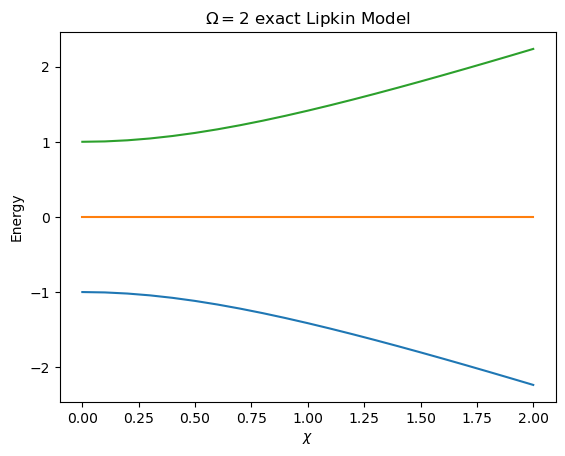

In [5]:
plt.plot(chi,EV0)
plt.plot(chi,EV1)
plt.plot(chi,EV2)
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.title('$\Omega=2$ exact Lipkin Model')

### Hartree Fock

A variational method in quantum mechanics, starts with the Schrodinger equation where one minimizes the energy for a given trail wave function $|\psi\rangle$.

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
\delta\frac{\langle\psi |\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}=0
\label{_auto7} \tag{32}
\end{equation}
$$

The Hartree Fock (HF) method is a variational method that assumes that
the exact N-body wavefunction of the system can be approimated by a
single Slater determinant, where energy of the system is minimized and
the trial wave function is the particle number conserving coherent
product state. The SU(2) coherent states map a two-dimensional sphere
known as the bloch sphere onto the complex plane,

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
\tau = tan\frac{\theta}{2}e^{-i\phi}
\label{_auto8} \tag{33}
\end{equation}
$$

where the normalized coherent SU(2) state can be written in the language of LM:

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
|\tau\rangle = \frac{1}{(1+|\tau|^2)^{\Omega/2}}e^{\tau\hat{K}_+}|\frac{\Omega}{2},-\frac{\Omega}{2}\rangle,
\label{_auto9} \tag{34}
\end{equation}
$$

The $E_{g.s}$ of the LM given HF coherent states is:

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
E(\tau) = \langle \tau|\hat{H}_{LM}|\tau\rangle.
\label{_auto10} \tag{35}
\end{equation}
$$

To calculate equation the last euation, we use generating functions for:

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}
\begin{split}
\langle \tau|\hat{J}_{z}|\tau\rangle &= \frac{1}{2}\Omega\frac{|\tau|^2-1}{\tau|^2+1}\\
\langle \tau|\hat{J}_{\pm}^2|\tau\rangle &= \Omega\frac{\tau^*}{|\tau|^2+1}
\end{split}
\label{_auto11} \tag{36}
\end{equation}
$$

Then using the definition of $\tau$ in equation (10) we can write down the energy:

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
E(\tau) = -\frac{\epsilon}{2}\Omega(cos\theta+\frac{\chi}{2}sin^2\theta cos2\phi),
\label{_auto12} \tag{37}
\end{equation}
$$

where $\chi=\frac{V}{\epsilon}(\Omega-1)$. Minimizing $E(\tau)$ with respect to $\theta,\phi$, we obtain the ground state Hartree Fock energy

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
\begin{split}
E_{HF}  = -\frac{\Omega}{2}\epsilon &\hspace{1cm} \chi<1\\
E_{HF}  = -\frac{\Omega}{4}\epsilon(\chi+\frac{1}{\chi}) &\hspace{1cm} \chi\ge 1
\end{split}
\label{_auto13} \tag{38}
\end{equation}
$$

In [6]:
def E_HF(x,E,omega):
  if x < 1:
    EHF = -(omega/2)*E
  elif x >= 1:
    EHF = -(omega/4)*E*(x+(1/x))
  return EHF

In [7]:
epsilon = 1
Omega = 2

HF = []
exact = []
for x in chi:
    HF.append(E_HF(x,epsilon,omega).real)
    v = Vp(epsilon,omega,x)
    e,h = quasi_spin(epsilon,v,omega)
    exact.append(e[0].real)

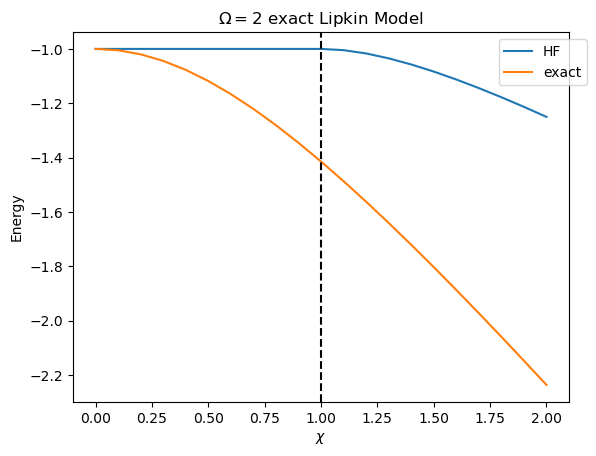

In [8]:
plt.plot(chi,HF,label='HF')
plt.plot(chi,exact,label='exact')
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.axvline(1, color = 'k', linestyle='--')
plt.title('$\Omega=2$ exact Lipkin Model')
plt.legend(bbox_to_anchor=(1.05, 1))

### Quantum Circuit

To solve the LM on a quantum computer we have to solve Schrodinger's equation.

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}
H|\psi(\tilde{\theta})\rangle = E|\psi(\tilde{\theta})\rangle\\
\label{_auto14} \tag{39}
\end{equation}
$$

We map the creation and annihilation operators to Pauli spin matrices/operators Z, X, Y (show this). The Hamiltonian then takes the form of

<!-- Equation labels as ordinary links -->
<div id="_auto15"></div>

$$
\begin{equation}
H = \frac{\epsilon}{2}(Z_0\otimes \boldsymbol{I}_1+Z_1\otimes \boldsymbol{I}_0) - \frac{V}{2}(X_0\otimes X_1 - Y_0\otimes Y_1),
\label{_auto15} \tag{40}
\end{equation}
$$

where the Pauli operators are the measurement basis which the quantum
circuit is measured in. The subscripts refer to quibits $0$ and $1$ respectively. Since we have two particles in this case, we end up with a two qubit state, as indicated
in the ansatz for the initial state here.
The Hamiltonian can thus we rewritten as a $4\times 4$ matrix acting on a two-qubit state. 

However, before measuring, we first have to
prepare the initial state $\vert\psi(\tilde{\theta})\rangle$ for
$\Omega=2$ of the LM circuit

$$
\begin{equation}
\vert\psi(\tilde{\theta})\rangle = \cos{ (\tilde{\theta})}\vert 00\rangle+\sin{(\tilde{\theta})}\vert 11\rangle,
end{equation}
$$

where $|00\rangle =|\uparrow\uparrow\rangle$, $|11\rangle=|\downarrow\downarrow\rangle$, and $\tilde{\theta}=\theta-\frac{\pi}{2}$. 

This type of problem resides in the pantheon of variational methods
where we minimize $\tilde{\theta}$. This problem was coded using IBM's
python library Qiskit. Since this is a variational problem, the use of
Qiskit's Variational Quantum Eigensolver (VQE) was used to find the
optimal $\tilde{\theta}$ that minimizes
$\langle\psi(\tilde{\theta})|H|\psi(\tilde{\theta})\rangle$.

In [9]:
def LM_circuit():
    theta = Parameter('theta')
    QC = QuantumCircuit(2)
    QC.ry(2*(theta-np.pi/2),0)
    QC.cnot(0,1)
    return QC

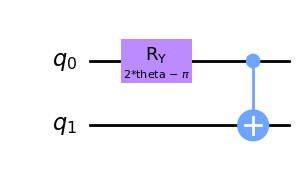

In [10]:
QC = LM_circuit()
QC.draw(output='mpl')

### VQE method

For this method, we will be using Qiskit's VQE function, where we specifiy 
* Quantum circuit

a. Optimizer

b. Quantum instance (i.e. which backend). Here we will be using the "qasm_simulator" 

c. Initial point (i.e. $\theta$ search space)

d. Hamiltonian/measurement basis

To define the Hamiltonian, we will use the Qiskit Pauli operator functions
I,Z,X,Y.  In this method, for a given $\chi$, we will do a search over
$\theta$ from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$ and picking out the
minimum energy value

In [ ]:
#sim1 min example
sim = Aer.get_backend('qasm_simulator')
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000) #optimizer for VQE
epsilon = 1
omega = 2
chi2 = [0.5,1]

t = np.arange(-pi/2,pi/2,0.05) #0.1 step size finishs pretty fast
energy = []
for x in chi2:
    ev = []
    v = Vp(epsilon,omega,x)
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) + 0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)
        ev.append(result.eigenvalue)
    energy.append(ev)


plt.plot(t,energy[0],label='$\chi=0.5$')
plt.plot(t,energy[1],label='$\chi=1$')
plt.xlabel('$\\theta$')
plt.ylabel('Ground State Energy')
plt.title('$E_{g.s}$ vs. $\\theta$')
plt.legend()

In [12]:
epsilon = 1
omega = 2
chi3 = np.arange(0,2.1,0.1)
t = np.arange(-pi/2,pi/2,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi3:
    v = Vp(epsilon,omega,x)
    ev = []
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)

        ev.append(result.eigenvalue)
    LM_sim.append(min(ev))

plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi3,LM_sim,label='QC sim',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega=2$')
plt.legend()

### VQE method using Qiskit

For this method, we will be using Qiskit's VQE function, where we specifiy 
1. Quantum circuit

2. Optimizer

3. Quantum instance (i.e. which backend). Here we will be using the "statevector_simulator" 

4. Hamiltonian/measurement basis

In [13]:
epsilon = 1
omega = 2
chi5 = np.arange(0,2.1,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi5:
    v = Vp(epsilon,omega,x)
    H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z )-0.5 * v * ( X ^ X ) + 0.5 * v * ( Y ^ Y )
    vec = Aer.get_backend('statevector_simulator')    
    vqe = VQE(ansatz=LM_circuit(),optimizer=adam,quantum_instance=vec,expectation=AerPauliExpectation())
    result = vqe.compute_minimum_eigenvalue(H)
    LM_sim.append(result.eigenvalue)


plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi5,LM_sim,label='QC state vec',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title('$\Omega=2$')
plt.legend()

Typically, running with Qiskit's own VQE is faster.

**Lecture next week we finalize the discussion of the VQE and the Lipkin model and discuss the quantum Fourier transform and the phase estimatiaon algorithm.**

1. Quantum Fourier transform

2. Phase estimation algorithm